<a id="top"></a>
# Team RM5 Classification Predict Notebook
### Kaggle Submission: Team_RM5_SigmoidFreuds
---
<img src="https://github.com/Lizette95/classification-predict-streamlit-template/blob/master/rm5_banner.png?raw=true" align="left">  

**Team Members:** Abednego Pakaree, Iman Mokwena, Lizette Loubser, Omphile Louw, Refiloe Elvis Phipa, Silindokuhle Kubheka    
**Supervisor:** Ridha Moosa

* [Notebook repo](https://github.com/Lizette95/Team_RM5_ClassificationPredict_Notebook)
* [Streamlit repo](https://github.com/Lizette95/classification-predict-streamlit-template)
* [Trello board](https://trello.com/b/pFKnwtGF/classificationteamrm5) 

### Table of Contents
---
1. [Introduction](#intro)
 * Background
 * Problem Statement
 * Datasets and Variables
---
2. [Load Dependencies](#imports)
---
3. [Data Cleaning](#cleaning)
 * Load Data
 * Remove Duplicate Rows
 * Remove Unwanted Columns
 * Remove Noise
---
4. [Exploratory Data Analysis](#EDA)
 * Data Summary
 * Target Variable
 * WordClouds
---
5. [Data Preprocessing](#preprocessing) 
---
6. [Modelling](#modelling)
---
7. [Performance Evaluation](#evaluation)
---
8. [Model Analysis](#analysis)
---
9. [Conclusion](#conclusion)
---
10. [Save Model and Output](#save)
---

<a id="intro"></a>
## 1. Introduction  

### Background

Machine learning is the study of computer algorithms that improve automatically through experience. It is a powerful branch of Artificial intelligence, dating as far back as 1952. Machine learning algorithms build a mathematical model based on sample data, known as "training data", in order to make predictions or decisions without being explicitly programmed to do so.

Classification is a process of categorizing a given set of data into classes, It can be performed on both structured or unstructured data. The process starts with predicting the class of given data points. The classes are often referred to as target, label or categories.


### Problem Statement

Build a classification model that will predict the sentiments of Tweets related to climate change.


### Datasets and Variables

**Datasets:**  
* train.csv: We will use this data to train our model.  
* test.csv: We will use this data to test our model.  

**Variables:**  
* sentiment: Sentiment of tweet  
* message: Tweet body  
* tweetid: Unique Twitter ID  

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:  

| Class | Description                                                                              |
| :----:|:-----------------------------------------------------------------------------------------|
| **2** |**News:** The tweet links to factual news about climate change                            |
| **1** |**Pro:** The tweet supports the belief of man-made climate change                         |
| **0** |**Neutral:** The tweet neither supports nor refutes the belief of man-made climate change |
| **-1**|**Anti:** The tweet does not believe in man-made climate change                           |

<a id="imports"></a>
## 2. Load Dependencies

In [0]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Prerequisites
#import sys
#!{sys.executable} -m pip install wordcloud scikit-learn

# Load Dependencies
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")

<a id="cleaning"></a>
## 3. Data Cleaning

### Load Data

In [0]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [0]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [0]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


### Remove Duplicate Rows

In [0]:
print('There are ' + str(train['message'].duplicated().sum()) + ' duplicate rows in the training set.')
print('There are ' + str(test['message'].duplicated().sum()) + ' duplicate rows in the testing set.')

There are 1590 duplicate rows in the training set.
There are 971 duplicate rows in the testing set.


In [0]:
train_data = train.drop_duplicates(subset='message', keep='first')
test_data = test.drop_duplicates(subset='message', keep='first')

### Remove Unwanted Columns

In [0]:
train_data = train_data.drop('tweetid', axis=1)
train_data['sentiment'] = train_data.pop('sentiment')
train_data.head()

,message,sentiment
0,PolySciMajor EPA chief doesn't think carbon di...,1
1,It's not like we lack evidence of anthropogeni...,1
2,RT @RawStory: Researchers say we have three ye...,2
3,#TodayinMaker# WIRED : 2016 was a pivotal year...,1
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",1


In [0]:
tweetid = test_data['tweetid'] #Save for Output File
test_data = test_data.drop('tweetid', axis=1)
test_data.head()

,message
0,Europe will now be looking to China to make su...
1,Combine this with the polling of staffers re c...
2,"The scary, unimpeachable evidence that climate..."
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...
4,RT @FakeWillMoore: 'Female orgasms cause globa...


### Remove Noise

In [0]:
def remove_noise(tweet):
    http_regex =r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    url_regex = r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)'
    rt_regex = r'^(RT|rt)( @\w*)?[: ]'
    new_tweet = tweet.replace('\n',' ') #Remove Newlines
    new_tweet = new_tweet.replace('"',' ') #Remove Text Delimeters
    new_tweet = new_tweet.replace('&amp',' ') #Remove Ampersands
    new_tweet = re.sub(http_regex, '', new_tweet) #Remove http URLs
    new_tweet = re.sub(url_regex, '', new_tweet) #Remove other URLs
    new_tweet = re.sub(rt_regex, '', new_tweet) #Remove RTs
    new_tweet = re.sub(r'#(RT|rt)*', '', new_tweet) #Remove RTs
    new_tweet = re.sub(r'@\w*', '', new_tweet) #Remove Mentions
    new_tweet = re.sub('\w*\d\w*','', new_tweet) #Remove Numbers/Words with Numbers
    new_tweet = re.sub('[^a-zA-z\s]', '', new_tweet) #Remove Punctuation
    new_tweet = new_tweet.lower() #Remove Capital Letters
    new_tweet = new_tweet.strip() #Remove Excess Whitespace
    return new_tweet

train_data['message'] = train_data['message'].apply(remove_noise)
test_data['message'] = test_data['message'].apply(remove_noise)

<a id="EDA"></a>
## 4. Exploratory Data Analysis

### Data Summary

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14229 entries, 0 to 15818
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    14229 non-null  object
 1   sentiment  14229 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 333.5+ KB


In [0]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9575 entries, 0 to 10545
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  9575 non-null   object
dtypes: object(1)
memory usage: 149.6+ KB


---
From the above summaries, we note that:
* None of our datasets have **missing values**
* There is no **sentiment** column in the test data, as this is our **target variable**
* There are **14 229** entries in our training dataset
* There are **9 575** entries in our testing dataset

### Target Variable   
We can examine the number of tweets that fall within a sentiment class and calculate the proportion of tweets that is represented by each class.

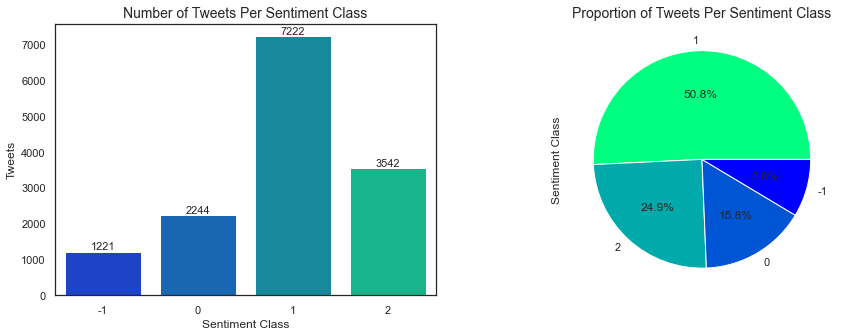

In [0]:
# Number of Tweets Per Sentiment Class
fig, axis = plt.subplots(ncols=2, figsize=(15, 5))

ax = sns.countplot(x='sentiment',data=train_data,palette='winter',ax=axis[0])
axis[0].set_title('Number of Tweets Per Sentiment Class',fontsize=14)
axis[0].set_xlabel('Sentiment Class')
axis[0].set_ylabel('Tweets')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')

train_data['sentiment'].value_counts().plot.pie(autopct='%1.1f%%',colormap='winter_r',ax=axis[1])
axis[1].set_title('Proportion of Tweets Per Sentiment Class',fontsize=14)
axis[1].set_ylabel('Sentiment Class')
    
plt.show()

The graphs reveal that our data is unbalanced, as 50% of the entries fall within sentiment class "1". This will have to be addressed when building our models.

### WordClouds   
Wordclouds can be used to visualise text data, where the frequency of each word is proportional to the word size.

In [0]:
# Make Wordclouds
def wc(df):
    words = ''
    for i in df: 
        i = str(i)
        tokens = i.split()   
        words += " ".join(tokens)+" "
    return words
# Training Set
train_words = wc(train_data['message'])
train_wordcloud = WordCloud(width=1500, height=700, background_color='white', colormap='winter', min_font_size=10).generate(train_words)
# Testing Set
test_words = wc(test_data['message'])
test_wordcloud = WordCloud(width=1500, height=700, background_color='white', colormap='winter_r', min_font_size=10).generate(test_words)

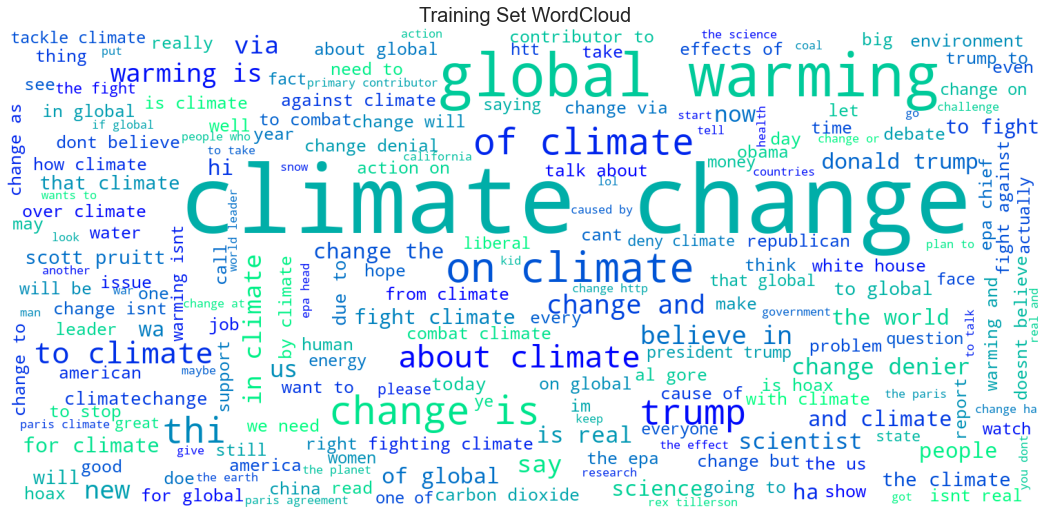

In [0]:
# Wordcloud for Training Data
plt.figure(figsize = (15, 7), facecolor = None) 
plt.title("Training Set WordCloud",fontsize=20)
plt.imshow(train_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

plt.show() 

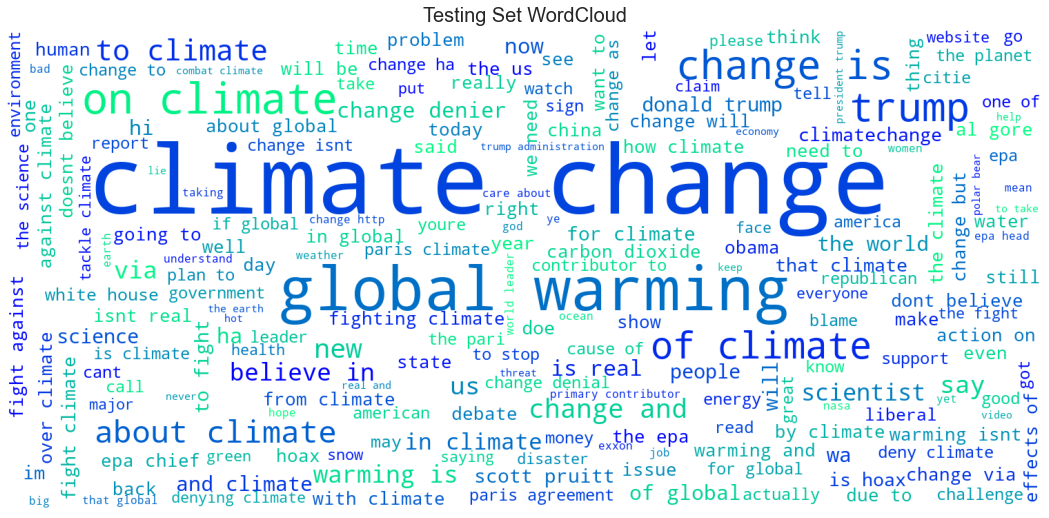

In [0]:
# Wordcloud for Testing Data
plt.figure(figsize = (15, 7), facecolor = None) 
plt.title("Testing Set WordCloud",fontsize=20)
plt.imshow(test_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

plt.show() 

<a id="preprocessing"></a>
## 5. Data Preprocessing

<a id="modelling"></a>
## 6. Modelling

<a id="evaluation"></a>
## 7. Performance Evaluation

<a id="analysis"></a>
## 8. Model Analysis

<a id="conclusion"></a>
## 9. Conclusion

<a id="save"></a>
## 10. Save Model and Output

In [0]:
# Create Kaggle submission file
# final_model = model(parameters)
# final_model.fit(X,y)
# y_test = final_model.predict(X_test)
# results = pd.DataFrame({"tweetid":test_data['tweetid'],"sentiment": y_test})
# results.to_csv("Team_RM5_submission.csv", index=False)

In [0]:
# Save model
# model_save_path = "Team_RM5_model.pkl"
# with open(model_save_path,'wb') as file:
#     pickle.dump(final_model,file)

[Back to top ↑](#top)